In [1]:
!pip install -U torchtext==0.8.0

     |████████████████████████████████| 7.0MB 6.2MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [2]:
!nvidia-smi

Wed Mar  3 18:05:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import io
import os
import numpy as np
import random
import torch
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import time
import re
import fileinput
import pickle
import time
from torchtext import datasets
import torchtext
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive/Colab Notebooks/nn_project')

Mounted at /content/drive


In [5]:
PICKLE_PATH = 'data/ynet_data.pkl'
MAX_LEN = 512
# Back Propogation Through Time
BPTT = 512
BATCH_SIZE = 12
EVAL_BATCH_SIZE = 6
EOS = '[EOS]'
SPECIAL_TOKENS = ['[SOS]', '[SUB]', '[EOS]', '[SEC]', '[UNK]'\
                  '[PAD]', '[UNK]', '[SEP]', '[SEP1]', '[SEP2]']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")                  

In [6]:
def char_tokenizer(text, special_tokens = SPECIAL_TOKENS):
    """
    TODO: ignore special chars - decrease vocab size
    Generator
    tokenizes text to chars, expcet for special tokens
    """
    for word in text.split():
        if word in special_tokens:
            yield word
        else:
            for char in word:
                yield char
            yield ' '

class PositionalEncoding(nn.Module):
    """
    Injects some information about the relative or absolute position of the
    tokens in the sequence. The positional encodings have the same dimension as
    the embeddings so that the two can be summed. Here, we use sine and cosine 
    functions of different frequencies.
    """
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # pe = positional encoding. Buffer = data that is not a model parameter but kept anyway
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)            

class TransformerModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5,\
                 num_meta=10, num_classes=12, min_time=1, max_time=2203):
        """
        Encoder only transformer (like Bert)
        :param ntoken - int: size of the dictionary of embeddings (num_embeddings)
        :param ninp: the number of expected features in the input (d_model). total size of embedding
        :param nhead: the number of heads in the multiheadattention models
        :param nhid: the dimension of the feedforward network model (torch default 2048)
        :param nlayers: number of encoder layers
        :param dropout: float, probability for dropout of a neuron
        """
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp - num_meta, dropout)
        self.num_classes = num_classes
        self.min_time = min_time
        self.max_time = max_time
        self.loss_list = []
        self.meta1_encoder = nn.Linear(self.num_classes, 5, bias=False)
        self.meta2_encoder = nn.Linear(1, 5, bias=False)
        # self-attn and feedforward network.
        # This standard encoder layer is based on the paper "Attention Is All You Need".
        # This has multiheaded_attention + add&norm + pointwise feed_forward (entire left encoder part)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        
        # TransformerEncoder is a stack of N encoder layers
        # This is the encoder only alot of stack for better encoding - this is the actual layer used
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        
        # A simple lookup table that stores embeddings of a fixed dictionary and size
        self.encoder = nn.Embedding(ntoken, ninp - num_meta) # -10 because we add two meta entries manually
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        """
        A square attention mask is required because the self-attention layers 
        in nn.TransformerEncoder are only allowed to attend the earlier 
        positions in the sequence. For the language modeling task, any tokens on
        the future positions should be masked.
        :param sz - : size?
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        self.meta1_encoder.weight.data.uniform_(-initrange, initrange)
        self.meta2_encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, data, src_mask):
        # Embedding
        src = data[:,:,0] # these are the letter tokens
        meta1 = data[:,:,1]  #/ self.num_classes # labels, scaled down by num classes
        # timestamp + min-max normalization
        meta2 = data[:,:,2] #(data[:,:,2] - self.min_time) / (self.max_time - self.min_time) 
        src = self.encoder(src) * math.sqrt(self.ninp)
        # Injects some information about the relative or absolute position of the tokens in the sequence
        src = self.pos_encoder(src)
        # Concat meta data as two single entries in the embedded state (no pos embedding)
        meta1 = F.one_hot(meta1, self.num_classes) 
        meta1 = self.meta1_encoder(meta1.float())
        meta2 = self.meta2_encoder(meta2.unsqueeze(2).float())
        src = torch.cat((src, meta1), 2)
        src = torch.cat((src, meta2), 2)
        # multi-head transformer
        output = self.transformer_encoder(src, src_mask)
        # fully connected linear
        output = self.decoder(output)
        return output

def data_process(data_iter, meta1_iter, meta2_iter):
    """
    Processes data and 2 metadata fileds
    First two entries for each item will be the meta entries (needs to be split in forward logic)
    """
    processed = torch.zeros((len(data_iter), MAX_LEN, 3), dtype=torch.long)
    for idx, (string, meta1, meta2) in enumerate(zip(data_iter, meta1_iter, meta2_iter)):
        tokenized = [vocab[token] for token in tokenizer(string)]
        if len(tokenized) < MAX_LEN:
            tokenized += ([vocab.stoi['[PAD]']] * (MAX_LEN - len(tokenized)))
        processed[idx][:,0] = torch.tensor(tokenized, dtype=torch.long)
        processed[idx][:,1] = torch.tensor(meta1, dtype=torch.long)
        processed[idx][:,2] = torch.tensor(meta2, dtype=torch.long)
        
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, processed)))

def batchify(data, bsz):
    # Divide the dataset into bsz parts. (bsz = batch size)
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
#     data = data.view(bsz, -1).t().contiguous()
    data = torch.transpose(data.view(bsz, -1, 3), 0, 1).contiguous()
#     yield data.to(device)
    return data.to(device)

def get_batch(source, i):
    """
    Generates the input and target sequence for the transformer model. 
    It subdivides the source data into chunks of length BPTT. 
    For the language modeling task, the model needs the following words 
    as Target.
    """
    seq_len = min(BPTT, len(source) - 1 - i)
    data = source[i:i+seq_len]
    # this is a good fix, even for alter when we use style transfer.
    target = source[i+1:i+1+seq_len].reshape(-1)[::3]
    return data, target

def train():
    """
    Trains one epoch - stochastic GD over an entire batch
    StepLR is applied to adjust the learn rate through epochs. 
    During the training, we use nn.utils.clip_grad_norm_ function to scale 
    all the gradient together to prevent exploding.
    """
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    # A square attention mask is required because the self-attention layers 
    # in nn.TransformerEncoder are only allowed to attend the earlier 
    # positions in the sequence.
    src_mask = model.generate_square_subsequent_mask(BPTT).to(device)
    for batch, i in enumerate(range(0, train_data_post.size(0) - 1, BPTT)):
        data, targets = get_batch(train_data_post, i)
        optimizer.zero_grad()
        # source data into chunks of length BPTT
        if data.size(0) != BPTT:
            # src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            print('got batch of size {0}, skipping'.format(data.shape))
            continue
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        save_interval = 2000
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data_post) // BPTT, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            model.loss_list.append(cur_loss)
            total_loss = 0
            start_time = time.time()
        if batch % save_interval == 0 and batch > 0:
            # v2 because we fear overfiting
            with open('saved_models/heb_char_model_onehot_v2.pkl', 'wb') as f:
                torch.save(model, f)
            print('saved model')

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(BPTT).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, BPTT):
            data, targets = get_batch(data_source, i)
            if data.size(0) != BPTT:
                # src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
                print('skipping sample eval because of shape: {0}'.format(data.shape))
                continue
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)    

def predict(X):
  """
  Recives unactivated output as 2D tensor 
  Predicts classes
  """
  activated = torch.softmax(X, dim=1)
  _, prediction = torch.max(activated, 1)
  return prediction
  
def generate(model, vocab, start_string, genre, timestamp, temperature, max_len):
    '''
    This function gets a trained model and vocab and generates a random string
    using the model, seeded with the start_string string.
    The temparature value is used to generate a more diverse output (high value),
    then a conservative one (low value).
    '''
        
    # remove the EOS, we don't need it for generation
    # TODO: ADD EOS TO DATA
    # sequence = sequence[:-1]
    
    model.eval()
    words = [w for w in tokenizer(start_string)]
    
    for i in range(max_len):
        sequence = vocab.lookup_indices(words)
        sequence_ten = torch.LongTensor(sequence)
        length = sequence_ten.shape[0]
        expanded = torch.stack((sequence_ten, torch.tensor([genre]*length),\
                            torch.tensor([timestamp]*length)), 1)
        src_mask = model.generate_square_subsequent_mask(len(sequence)).to(device)
        forward = model(expanded.unsqueeze(1).to(device), src_mask)
        prediction = predict(forward[-1])
        next_word = vocab.itos[prediction]
        if next_word == EOS:
            i = max_len + 1
        else:
            words.append(next_word)
    return words

In [7]:
data = pd.read_pickle(PICKLE_PATH)
label_dict = {key: value for value, key in enumerate(data.label.unique())}

train_len = int(len(data) * 0.9)
train_data = data[0:train_len]
val_data = data[train_len:]

tokenizer = char_tokenizer
vocab = build_vocab_from_iterator(map(tokenizer,
                                      train_data['data'].__iter__()))

# Conform vocab to Bert standarts
# vocab.itos[0] = '[UNK]'
# vocab.itos[1] = '[PAD]'
# vocab.stoi['[UNK]'] = 0
# vocab.stoi['[PAD]'] = 1
# vocab.stoi.pop('<pad>')
# vocab.stoi.pop('<unk>')
# vocab.UNK = '[UNK]'

train_text_data = train_data['data']
train_label_data = train_data['label_num']
train_time_data = train_data['date'] - 2e5

val_text_data = val_data['data']
val_label_data = val_data['label_num']
val_time_data = val_data['date'] - 2e5

train_data_pre = data_process(train_text_data,\
                              train_label_data, train_time_data)
val_data_pre = data_process(val_text_data,\
                            val_label_data, val_time_data)

train_data_post = batchify(train_data_pre, BATCH_SIZE)
val_data_post = batchify(val_data_pre, EVAL_BATCH_SIZE)

237033lines [00:25, 9184.16lines/s]


In [8]:
# sanity check
[vocab.itos[int(c)] for c in train_data_post[0:10][:,0][:,0]]

['[SOS]', 'צ', 'ה', '"', 'ל', ' ', 'א', 'י', 'ת', 'ר']

In [7]:
ntokens = len(vocab.stoi) # the size of vocabulary
emsize = 768 # embedding dimension - 768 like in BERT
nhid = 3072 # the dimension of the feedforward network model in nn.TransformerEncoder - 3072 like in BERT
nlayers = 12 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder - we put 12 like in BERT
nhead = 12 # the number of heads in the multiheadattention models - we put 12 like in BERT
dropout = 0.1 # the dropout value - 0.1 like in BERT
# model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)
model = torch.load('saved_models/heb_char_model_onehot_v2.pkl')

NameError: ignored

In [34]:
criterion = nn.CrossEntropyLoss()
# lr = 5e-5 # learning rate
lr = 3e-5 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [34]:
torch.cuda.empty_cache()
import gc
# del variables
gc.collect()  

2276

In [ ]:
%%time
best_val_loss = float("inf")
epochs = 40 # The number of epochs
best_model = None

model.cuda()

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data_post)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        with open('heb_char_model.pkl', 'wb') as f:
            torch.save(model, f)

    scheduler.step()

In [71]:
model.eval() # Turn on the evaluation mode

# ['צבאי', 'משפט ופלילי', 'בריאות וחינוך', 'כלכלה עולמית', 'כללי', 'פוליטי'
# 'כלכלה ישראל', 'כדורגל', 'פלסטינים', 'סקס', 'סקס ויחסים', ';כלכלה עולמית']
genre = label_dict['כללי']
timestamp = 1000

start_string = """עזר"""
# start_string = """איש העסקים האמריקאי"""
# start_string = """שר הכדורגל ויו"ר התאגדות המנופאים"""
# start_string = """איך תדעי אם השותף שלך אוהב אותך?"""
# start_string = """ תושב כפר סבא חשוד כי סחר בחמוסים"""
# start_string = """[SOS] מחסור בחמאה בעקבות שביתה בנמל [SEP1] ברחבי הארץ הורגש מחסור חמור בחמאה לקראת חג הפסח [SEP2] """
# start_string = """הרשות הפלסטינית תחלק ממתקים למתנחלים לכבוד פסח"""
# start_string = '[SOS] ' + start_string
# start_string = '[SOS] ' + start_string + ' [SEP1]'


generated_text = ''
with torch.no_grad():
    generated = generate(model, vocab, start_string, genre, timestamp, 1, 500)
for char in generated:
    generated_text += char
print(generated_text)
print(' ')

עזר במיוחד לאחר שהורשע בהריגת הנער במסעדה בירושלים במסעדה בירושלים. הוא הורשע בהריגת הנער במסעדה בירושלים במסעדה בירושלים. הנער הורשע בהריגת הנער במסעדה בירושלים במסעדה בירושלים. הנער הורשע בהריגת הנער במסעדה בירושלים במסעדה בירושלים. הנער הו 
 


In [10]:
genres = data.label.unique()
generated_articles = []

In [40]:
start_string_list = [
                     """ראש הממשלה""",
                     """נתינהו:""",
                     """שר הבריאות""",
                     """גאווה ישראלית""",
                     """משואה לתקומה""",
                     """הישג אדיר""",
                     """התפתחות מפתיעה""",
                     """מועצת החכמים""",
                     """איגוד יצרני""",
                     """מפכ"ל המשטרה:""",
                     """שר הביטחון:""",
                     """ירידות חדות""",
                     """זינוק""",
                     """נשיא המדינה""",
                     """השרים אישרו""",
                     """הקבינט התכנס""",
                     """מה קרה""",
                     """מי גנב""",
                     """מה קורה""",
                     """אלף ימים""",
                     """עלייתו ונפילתו""",
                     """אזהרה: """,
                     """אין גבול""",
                     """המלחמה נמשכת:""",
                     """דווקא אחרי""",
                     """ראש המל"ל""",
                     """עשרות חמוסים""",
                     """קרב צמוד בין""",
                     """תגלית מפתיעה""",
]

In [43]:
a = """בלה בלה ynet בלה"""
a.replace('ynet', 'whynet')

'בלה בלה whynet בלה'

In [45]:
%%time
generated_articles = []
for start_string in start_string_list:
    start_string = '[SOS] ' + start_string
    for label in genres:
        genre = label_dict[label]
        year = random.randint(0,21) * 100
        month = random.randint(0,12)
        day = random.randint(0,29)
        timestamp = year + month
        generated_text = ''
        with torch.no_grad():
            generated = generate(model, vocab, start_string, genre, timestamp, 1, 512)
        for char in generated:
            generated_text += char

        title = generated_text.split('[SEP1]')[0].strip('[SOS] ')
        try:
            sub_title = generated_text.split('[SEP1]')[1].split('[SEP2]')[0].strip('[SEP1] ')
        except IndexError:
            sub_title = ''
        try:
            body = generated_text.split('[SEP1]')[1].split('[SEP2]')[1].strip('[SEP2]')
        except IndexError:
            body = ''

        tilte = title.replace('ynet', 'whynet')
        sub_tilte = title.replace('ynet', 'whynet')
        body = title.replace('ynet', 'whynet')

        generated_articles.append((start_string, genre, "{0}.{1}.{2}"\
                                   .format(day, month, (year // 100) + 2000) ,\
                                   title, sub_title, body))

CPU times: user 1h 29min 30s, sys: 6min 42s, total: 1h 36min 13s
Wall time: 50min 25s


In [ ]:
new_list = []
for i in range(0, len(generated_articles)):
    new_list.append([item for item in generated_articles[i]])

In [27]:
new_list

NameError: ignored

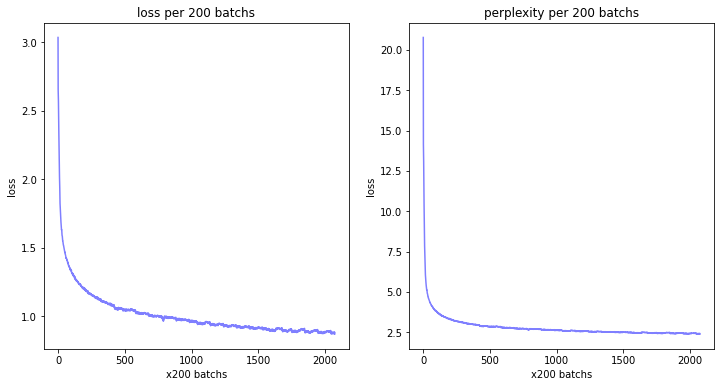

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('loss per 200 batchs')
_ = axes[0].plot(model.loss_list, color='blue', alpha=0.5)
axes[1].set_title('perplexity per 200 batchs')
_ = axes[1].plot(np.exp(np.array(model.loss_list)), color='blue', alpha=0.5)
_ = axes[0].set_xlabel('x200 batchs')
_ = axes[0].set_ylabel('loss')
_ = axes[1].set_xlabel('x200 batchs')
_ = axes[1].set_ylabel('loss')